# <center>MNIST Classification using MLP</center> 



In [1]:
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print('train_X: ' + str(train_X.shape))
print('train_y: ' + str(train_y.shape))
print('test_X:  '  + str(test_X.shape))
print('test_y:  '  + str(test_y.shape))


11501568/11490434 [==============================] - 0s 0us/step
train_X: (60000, 28, 28)
train_y: (60000,)
test_X:  (10000, 28, 28)
test_y:  (10000,)


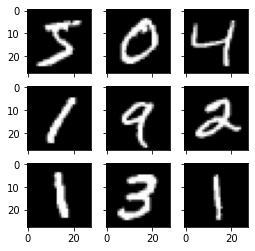

In [2]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
for i in range(3):
    for j in range(3):
        ax[i][j].imshow(train_X[i*3+j], cmap=plt.get_cmap("gray"))
# show the plot
plt.show()

In [3]:
# reshape 
import numpy as np
train_X = np.array(train_X.reshape(train_X.shape[0] ,784)).T   
test_X = np.array(test_X.reshape(test_X.shape[0] ,784)).T
train_X = (train_X/255.0).astype(np.float32)
test_X = (test_X/255.0).astype(np.float32)


# $\color{purple}{\text{1.1 BaseLine Model with Activation Sigmoid}}$
             
    Size = [784, 500, 250, 100,10]
    Activation function: Sigmoid
    Loss: Cross entropy
    learning_rate = 0.01
    batch_size = 64
    epoch = 15
    initialization: GLOROT / Xavier




In [4]:
import numpy as np
import time

class DeepNeuralNetwork():
    def __init__(self, sizes,epochs=15, l_rate=0.01,activation_function = 'sigmoid',batch_size = 64):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.batch_size = batch_size
        #self.train_X = train_X
        #self.train_y = train_y
        #Activation function
        self.activation_function = self.activation(activation_function)

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def activation(self, activation_function):
        if activation_function == 'sigmoid':
          return self.sigmoid
        if activation_function == 'tanh':
          return self.tanh
        if activation_function == 'relu':
          return self.relu

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        else:    
            return 1/(1 + np.exp(-x))

    def tanh(self, x, derivative = False):
        if derivative:
            return 1 - self.tanh(x)**2
        else:    
            return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    def relu(self, x, derivative = False):
        if derivative:
          return (x>0)*1 
        else:
          return x*(x>0)        

    def softmax(self, x, derivative=False):
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        else:    
            return exps / np.sum(exps, axis=0)
    def one_hot(self,y):
        v = np.zeros((self.sizes[4], len(y)))
        for i,j in enumerate(y):
          v[j,i] = 1
        return v       

    def initialization(self):
        w = []
        b = []
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        hidden_3=self.sizes[3]
        output_layer=self.sizes[4]
        self.W1 = np.random.randn(hidden_1, input_layer)*np.sqrt(6/(input_layer+hidden_1))
        self.W2 = np.random.randn(hidden_2, hidden_1)*np.sqrt(6/(hidden_1+hidden_2))
        self.W3 = np.random.randn(hidden_3, hidden_2)*np.sqrt(6/(hidden_2+hidden_3))
        self.W4 = np.random.randn(output_layer, hidden_3)*np.sqrt(6/(hidden_3+output_layer))
        w.append(self.W1)
        w.append(self.W2)
        w.append(self.W3)
        w.append(self.W4)

        self.b1 = np.zeros((hidden_1, 1))
        self.b2 = np.zeros((hidden_2,1))
        self.b3 = np.zeros((hidden_3,1))
        self.b4 = np.zeros((output_layer,1))
        b.append(self.b1)
        b.append(self.b2)
        b.append(self.b3)
        b.append(self.b4)
        
        return {'w':w, 'b':b}

    def compute_accuracy(self, test_X, test_y):
        from sklearn.metrics import accuracy_score
        out = self.forward_pass(test_X)
        pred = np.argmax(out, axis = 0)
        acc=accuracy_score(test_y, pred, normalize=True, sample_weight=None)
        return np.mean(pred == test_y)*100    

    def forward_pass(self, train_X):
        self.a = []  # Input to the activation layer 
        self.h = []  # Input to the hidden layer # Output of the activation 
        self.h.append(train_X)

        self.a1 =(self.params['w'][0]).dot(self.h[-1]) + self.params['b'][0]
        self.h1 = self.activation_function(self.a1)
        self.h.append(self.h1)
        self.a.append(self.a1)


        self.a2 = (self.params['w'][1]).dot(self.h1) + self.params['b'][1]
        self.h2 = self.activation_function(self.a2)
        self.h.append(self.h2)
        self.a.append(self.a2)
         
        self.a3 = (self.params['w'][2]).dot(self.h2) + self.params['b'][2]
        self.h3 = self.activation_function(self.a3)
        self.h.append(self.h3) 
        self.a.append(self.a3)

        self.a4 = (self.params['w'][3]).dot(self.h3) + self.params['b'][3]
        y_hat = self.softmax(self.a4)        
        return y_hat

      

    def backward_pass(self, train_y, output):
        params = self.params
        self.da = [0]* 4
        self.dh = [0]* 3
        self.dw = [0]* 4
        self.db = [0]* 4

        self.da[-1] = -1*(train_y - output) # last layer 
        m = output.shape[1]

        self.dw[3] = 1./m * np.dot(self.da[3], self.h[3].T) 
        self.db[3] = 1./m * np.sum(self.da[3], axis = 1, keepdims = True)
        self.dh[2] = np.dot(self.params['w'][3].T, self.da[3])
        self.da[2] = np.multiply(self.dh[2], self.activation_function(self.da[2], derivative=True)) 

        self.dw[2] = 1./m * np.dot(self.da[2], self.h[2].T) 
        self.db[2] = 1./m * np.sum(self.da[2], axis = 1, keepdims = True)
        self.dh[1] = np.dot(self.params['w'][2].T, self.da[2])
        self.da[1] = np.multiply(self.dh[1], self.activation_function(self.da[1], derivative=True)) 

        self.dw[1] = 1./m * np.dot(self.da[1], self.h[1].T) 
        self.db[1] = 1./m * np.sum(self.da[1], axis = 1, keepdims = True)
        self.dh[0] = np.dot(self.params['w'][1].T, self.da[1])
        self.da[0] = np.multiply(self.dh[0], self.activation_function(self.da[0], derivative=True)) 

        self.dw[0] = 1./m * np.dot(self.da[0], self.h[0].T)
        self.db[0] = 1./m * np.sum(self.da[0], axis = 1, keepdims = True)

        return self.dw, self.db
    

    def update_network_parameters(self, gW, gB):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y), 
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''


        W = np.array(self.params['w'], dtype = object)
        B = np.array(self.params['b'], dtype = object)
        W = W - self.l_rate * np.array(gW, dtype = object)
        B = B - self.l_rate * np.array(gB, dtype = object)
        return {'w':W.tolist(), 'b': B.tolist()}    
    def loss(self, y_pred, y_true):
          return -1*np.mean(np.multiply(y_true, np.log(y_pred)))       

    def accuracy(self, X, y):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(X, y):
            output = self.forward_pass(X)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))
        
        return np.mean(predictions)
    def compute_accuracy(self, test_X, test_y):
        from sklearn.metrics import accuracy_score
        out = self.forward_pass(test_X)
        pred = np.argmax(out, axis = 0)
        acc=accuracy_score(test_y, pred, normalize=True, sample_weight=None)
        return np.mean(pred == test_y)*100    

    def train(self,train_X, train_y, test_X, test_y):
        from tqdm.auto import tqdm
        N = train_X.shape[1]
        n_batches = int(np.floor(N / self.batch_size))
        train_iter_loss = []
        test_iter_loss = []
        train_epoch_loss = []
        start_time = time.time()
        for i in range(self.epochs):
            #for x,y in zip(train_X, train_y):
            l=0
            for batch in tqdm(range(0, n_batches)):
                x = train_X[:,batch*self.batch_size:self.batch_size+batch*self.batch_size]
                y = train_y[batch*self.batch_size:self.batch_size+batch*self.batch_size]
                output = self.forward_pass(x)
                gw,gb= self.backward_pass(self.one_hot(y), output)
                self.params = self.update_network_parameters(gw,gb)
                l += self.loss(output, self.one_hot(y))
                if batch % 200 == 0:
                  train_iter_loss.append(self.loss(self.forward_pass(train_X),self.one_hot(train_y)))
                  test_iter_loss.append(self.loss(self.forward_pass(test_X),self.one_hot(test_y)))
            try:
              x = train_X[:,-1*N%n_batches:]
              y = train_y[-1*N%n_batches:]
              output = self.forward_pass(x)
              gW, gB = self.backward_pass(self.one_hot(y), output)
              self.params = self.update_network_parameters(gw,gb)
              l += self.loss(output, self.one_hot(y))
            except:
              pass      
            train_epoch_loss.append(l/N)
            accuracy_train = self.compute_accuracy(train_X, train_y)
            accuracy_test= self.compute_accuracy(test_X, test_y)
    
            print('Epoch: {0}, Time Spent: {1:.2f}s, AccuracyTrain: {2:.2f}, AccuracyTrain: {2:.2f}%'.format(
                i+1, time.time() - start_time, accuracy_train, accuracy_test ))
            print(f"Epoch-loss: {l/N}")
        return train_iter_loss, test_iter_loss, train_epoch_loss   
            
#dnn1 = DeepNeuralNetwork(sizes=[784, 500, 250, 100, 10],epochs=15, l_rate=0.01,activation_function = 'sigmoid',batch_size = 64)
#train_iter_loss1, test_iter_loss1, train_epoch_loss1 = dnn1.train(train_X,train_y, test_X, test_y)

In [5]:
dnn1 = DeepNeuralNetwork(sizes=[784, 500, 250, 100, 10],epochs=15, l_rate=0.01,activation_function = 'sigmoid',batch_size = 64)
train_iter_loss1, test_iter_loss1, train_epoch_loss1 = dnn1.train(train_X,train_y, test_X, test_y)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, Time Spent: 56.19s, AccuracyTrain: 56.62, AccuracyTrain: 56.62%
Epoch-loss: 0.003404283569726803


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, Time Spent: 141.23s, AccuracyTrain: 67.02, AccuracyTrain: 67.02%
Epoch-loss: 0.0028274006661716273


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, Time Spent: 197.16s, AccuracyTrain: 75.11, AccuracyTrain: 75.11%
Epoch-loss: 0.002104877840675815


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, Time Spent: 241.97s, AccuracyTrain: 79.33, AccuracyTrain: 79.33%
Epoch-loss: 0.001570966383987209


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, Time Spent: 287.66s, AccuracyTrain: 82.06, AccuracyTrain: 82.06%
Epoch-loss: 0.0012347083908073573


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, Time Spent: 333.80s, AccuracyTrain: 83.82, AccuracyTrain: 83.82%
Epoch-loss: 0.001035183973042272


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, Time Spent: 381.29s, AccuracyTrain: 85.16, AccuracyTrain: 85.16%
Epoch-loss: 0.0009110960701889827


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, Time Spent: 428.10s, AccuracyTrain: 86.21, AccuracyTrain: 86.21%
Epoch-loss: 0.0008271603967974064


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, Time Spent: 476.43s, AccuracyTrain: 86.99, AccuracyTrain: 86.99%
Epoch-loss: 0.0007665269829776523


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, Time Spent: 526.89s, AccuracyTrain: 87.64, AccuracyTrain: 87.64%
Epoch-loss: 0.000720697882936514


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, Time Spent: 575.68s, AccuracyTrain: 88.18, AccuracyTrain: 88.18%
Epoch-loss: 0.0006849157670089108


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, Time Spent: 622.82s, AccuracyTrain: 88.56, AccuracyTrain: 88.56%
Epoch-loss: 0.0006562385427619587


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, Time Spent: 670.01s, AccuracyTrain: 88.83, AccuracyTrain: 88.83%
Epoch-loss: 0.0006327221882980693


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, Time Spent: 718.75s, AccuracyTrain: 89.09, AccuracyTrain: 89.09%
Epoch-loss: 0.0006130356580592376


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 15, Time Spent: 766.06s, AccuracyTrain: 89.31, AccuracyTrain: 89.31%
Epoch-loss: 0.0005962479269851003


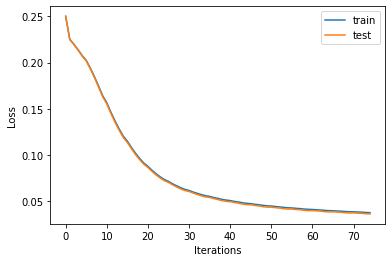

In [6]:
plt.plot(train_iter_loss1, label = 'train')
plt.plot(test_iter_loss1, label = 'test')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

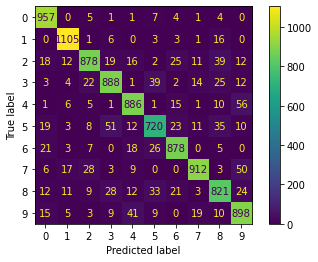

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_test_pred1 = dnn1.forward_pass(test_X)
y_test_pred1 = np.argmax(y_test_pred1, axis = 0)
cm1 = confusion_matrix(test_y, y_test_pred1, labels=list(range(0,10)))
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=list(range(0,10)))
disp1.plot()

In [8]:
from sklearn.metrics import classification_report
print(classification_report(test_y.tolist(), y_test_pred1.tolist(), target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       980
           1       0.95      0.97      0.96      1135
           2       0.91      0.85      0.88      1032
           3       0.88      0.88      0.88      1010
           4       0.89      0.90      0.90       982
           5       0.86      0.81      0.83       892
           6       0.90      0.92      0.91       958
           7       0.94      0.89      0.91      1028
           8       0.85      0.84      0.85       974
           9       0.85      0.89      0.87      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [10]:
print(f"Train Accuracy: {dnn1.compute_accuracy(train_X, train_y)}")
print(f"Test Accuracy: {dnn1.compute_accuracy(test_X, test_y)}")

Train Accuracy: 89.30833333333334
Test Accuracy: 89.42999999999999


# $\color{purple}{\text{1.2 BaseLine Model with Activation Tanh}}$




In [11]:
dnn2 = DeepNeuralNetwork(sizes=[784, 500, 250, 100, 10],epochs=15, l_rate=0.01,activation_function = 'tanh',batch_size = 64)
train_iter_loss2, test_iter_loss2, train_epoch_loss2 = dnn2.train(train_X,train_y, test_X, test_y)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, Time Spent: 79.26s, AccuracyTrain: 89.24, AccuracyTrain: 89.24%
Epoch-loss: 0.000650813079962164


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, Time Spent: 152.09s, AccuracyTrain: 90.41, AccuracyTrain: 90.41%
Epoch-loss: 0.000493572998570178


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, Time Spent: 230.09s, AccuracyTrain: 91.03, AccuracyTrain: 91.03%
Epoch-loss: 0.00045912545283742625


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, Time Spent: 304.95s, AccuracyTrain: 91.40, AccuracyTrain: 91.40%
Epoch-loss: 0.0004372890681687463


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, Time Spent: 378.44s, AccuracyTrain: 91.67, AccuracyTrain: 91.67%
Epoch-loss: 0.0004215582306019268


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, Time Spent: 453.64s, AccuracyTrain: 91.90, AccuracyTrain: 91.90%
Epoch-loss: 0.00040940111328269095


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, Time Spent: 527.21s, AccuracyTrain: 92.06, AccuracyTrain: 92.06%
Epoch-loss: 0.0003995218746659323


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, Time Spent: 601.75s, AccuracyTrain: 92.24, AccuracyTrain: 92.24%
Epoch-loss: 0.0003911978641610508


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, Time Spent: 675.54s, AccuracyTrain: 92.37, AccuracyTrain: 92.37%
Epoch-loss: 0.0003840013537046348


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, Time Spent: 749.96s, AccuracyTrain: 92.45, AccuracyTrain: 92.45%
Epoch-loss: 0.0003776604389707881


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, Time Spent: 825.50s, AccuracyTrain: 92.55, AccuracyTrain: 92.55%
Epoch-loss: 0.00037198994219030226


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, Time Spent: 902.95s, AccuracyTrain: 92.63, AccuracyTrain: 92.63%
Epoch-loss: 0.000366860352452934


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, Time Spent: 977.42s, AccuracyTrain: 92.66, AccuracyTrain: 92.66%
Epoch-loss: 0.0003621811947049876


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, Time Spent: 1050.90s, AccuracyTrain: 92.72, AccuracyTrain: 92.72%
Epoch-loss: 0.00035788914453693


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 15, Time Spent: 1125.59s, AccuracyTrain: 92.79, AccuracyTrain: 92.79%
Epoch-loss: 0.00035394167767588403


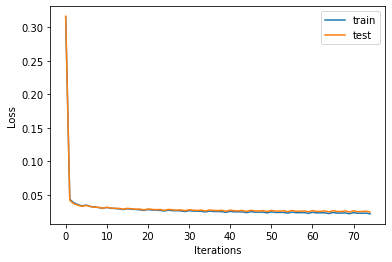

In [12]:
plt.plot(train_iter_loss2, label = 'train')
plt.plot(test_iter_loss2, label = 'test')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

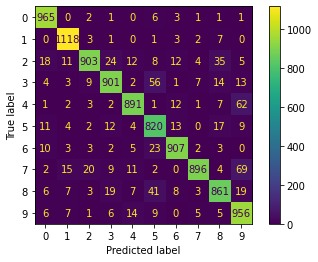

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_test_pred2 = dnn2.forward_pass(test_X)
y_test_pred2 = np.argmax(y_test_pred2, axis = 0)
cm2 = confusion_matrix(test_y, y_test_pred2, labels=list(range(0,10)))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=list(range(0,10)))
disp2.plot()

In [14]:
from sklearn.metrics import classification_report
print(classification_report(test_y.tolist(), y_test_pred2.tolist(), target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.96      0.99      0.97      1135
           2       0.95      0.88      0.91      1032
           3       0.92      0.89      0.91      1010
           4       0.94      0.91      0.92       982
           5       0.85      0.92      0.88       892
           6       0.95      0.95      0.95       958
           7       0.97      0.87      0.92      1028
           8       0.90      0.88      0.89       974
           9       0.84      0.95      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [15]:
print(f"Train Accuracy: {dnn2.compute_accuracy(train_X, train_y)}")
print(f"Test Accuracy: {dnn2.compute_accuracy(test_X, test_y)}")

Train Accuracy: 92.78999999999999
Test Accuracy: 92.17999999999999


# $\color{purple}{\text{1.3 BaseLine Model with Activation ReLu}}$:


In [16]:
dnn3 = DeepNeuralNetwork(sizes=[784, 500, 250, 100, 10],epochs=15, l_rate=0.01,activation_function ='relu',batch_size = 64)
train_iter_loss3, test_iter_loss3, train_epoch_loss3 = dnn3.train(train_X,train_y, test_X, test_y)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, Time Spent: 35.58s, AccuracyTrain: 57.00, AccuracyTrain: 57.00%
Epoch-loss: 0.0029677142132645677


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, Time Spent: 72.17s, AccuracyTrain: 66.73, AccuracyTrain: 66.73%
Epoch-loss: 0.0018850496400588843


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, Time Spent: 107.86s, AccuracyTrain: 70.25, AccuracyTrain: 70.25%
Epoch-loss: 0.0016030970182922535


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, Time Spent: 143.58s, AccuracyTrain: 72.24, AccuracyTrain: 72.24%
Epoch-loss: 0.0014688557120364311


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, Time Spent: 180.18s, AccuracyTrain: 73.41, AccuracyTrain: 73.41%
Epoch-loss: 0.0013874367170711337


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, Time Spent: 215.52s, AccuracyTrain: 74.30, AccuracyTrain: 74.30%
Epoch-loss: 0.0013314486677625617


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, Time Spent: 251.11s, AccuracyTrain: 74.91, AccuracyTrain: 74.91%
Epoch-loss: 0.001289947166937472


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, Time Spent: 286.57s, AccuracyTrain: 75.39, AccuracyTrain: 75.39%
Epoch-loss: 0.0012576264573864575


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, Time Spent: 327.93s, AccuracyTrain: 75.90, AccuracyTrain: 75.90%
Epoch-loss: 0.001231562888102567


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, Time Spent: 363.21s, AccuracyTrain: 76.24, AccuracyTrain: 76.24%
Epoch-loss: 0.001209993080306579


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, Time Spent: 398.75s, AccuracyTrain: 76.55, AccuracyTrain: 76.55%
Epoch-loss: 0.0011917801030141744


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, Time Spent: 435.86s, AccuracyTrain: 76.81, AccuracyTrain: 76.81%
Epoch-loss: 0.0011761525732158994


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, Time Spent: 471.35s, AccuracyTrain: 77.04, AccuracyTrain: 77.04%
Epoch-loss: 0.0011625657109489052


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, Time Spent: 506.91s, AccuracyTrain: 77.25, AccuracyTrain: 77.25%
Epoch-loss: 0.0011506221522875626


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 15, Time Spent: 542.68s, AccuracyTrain: 77.44, AccuracyTrain: 77.44%
Epoch-loss: 0.0011400242765227451


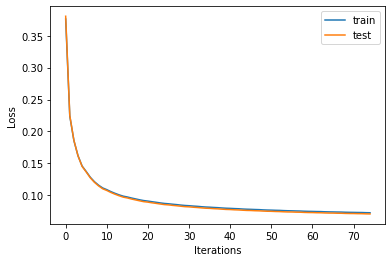

In [17]:
plt.plot(train_iter_loss3, label = 'train')
plt.plot(test_iter_loss3, label = 'test')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

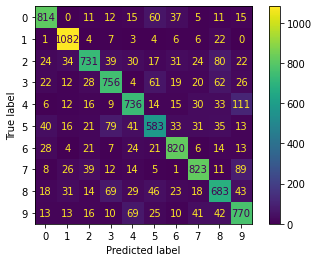

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_test_pred3 = dnn3.forward_pass(test_X)
y_test_pred3 = np.argmax(y_test_pred3, axis = 0)
cm3 = confusion_matrix(test_y, y_test_pred3, labels=list(range(0,10)))
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3,display_labels=list(range(0,10)))
disp3.plot()

In [19]:
from sklearn.metrics import classification_report
print(classification_report(test_y.tolist(), y_test_pred3.tolist(), target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       980
           1       0.88      0.95      0.92      1135
           2       0.81      0.71      0.76      1032
           3       0.76      0.75      0.75      1010
           4       0.76      0.75      0.76       982
           5       0.70      0.65      0.67       892
           6       0.82      0.86      0.84       958
           7       0.82      0.80      0.81      1028
           8       0.69      0.70      0.69       974
           9       0.70      0.76      0.73      1009

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



In [20]:
print(f"Train Accuracy: {dnn3.compute_accuracy(train_X, train_y)}")
print(f"Test Accuracy: {dnn3.compute_accuracy(test_X, test_y)}")

Train Accuracy: 77.445
Test Accuracy: 77.98


# $\color{purple}{\text{Results Observed}}$


After using Tanh activation function we are getting best accuracy. So it performs the best.
While by using relu activation function our model becomes the fastest of all.